In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [6]:
import math

def determine_direction(dx, dy, num_sectors):
    """
    Determines the directional label for a given dx, dy pair based on the specified number of polar sectors,
    with the first sector centered at 0 degrees (directly to the right).

    Parameters:
    - dx: Change in x-coordinate.
    - dy: Change in y-coordinate.
    - num_sectors: Number of sectors to divide the polar coordinate system into.

    Returns:
    - A vector of length num_sectors with a 1 at the index corresponding to the sector of the dx, dy pair,
      and 0s elsewhere.
    """
    if num_sectors < 1:
        raise ValueError("Number of sectors must be at least 1.")
    
    angle = math.atan2(dy, dx)
    angle_degrees = (math.degrees(angle) + 360) % 360
    degrees_per_sector = 360 / num_sectors
    adjusted_angle_degrees = (angle_degrees + degrees_per_sector / 2) % 360
    sector = int(adjusted_angle_degrees // degrees_per_sector)
    
    # Initialize a vector with zeros
    direction_vector = [0] * num_sectors
    # Set the appropriate sector to 1
    direction_vector[sector] = 1

    return direction_vector




#### Importing data


In [17]:
data_paths = [  r"processed_data\section_1\sample_1.pkl", 
 #               r"processed_data\section_1\sample_2.pkl",
 #               r"processed_data\section_2\sample_1.pkl",
 #               r"processed_data\section_2\sample_2.pkl",
 #               r"processed_data\section_3\sample_1.pkl",
 #               r"processed_data\section_3\sample_2.pkl",
 #               r"processed_data\section_4\sample_2.pkl",
 #               r"processed_data\section_5\sample_2.pkl",
 #               r"processed_data\section_5\sample_3.pkl",
 #               r"processed_data\section_6\sample_1.pkl",
 #               r"processed_data\section_6\sample_2.pkl",
]
window_size = 1000
stride = 1000
num_stacked = 3
training_data_all = pd.DataFrame()


for data_path in data_paths:
    name = data_path.split("\\")
    section = name[1]
    sample = name[2].split(".")[0]

    training_data = pd.read_pickle(data_path)

    # Creating windowed slices of the data


    training_data_all = pd.DataFrame(columns = ['sensor_1', 'sensor_2', 'sensor_3', 't', 'x', 'y'])
    
    for i in tqdm(range(0, len(training_data) - window_size, stride)):
        s1 = training_data.sensor_1.iloc[i:i+window_size]
        s2 = training_data.sensor_2.iloc[i:i+window_size]
        s3 = training_data.sensor_3.iloc[i:i+window_size]
        t =  training_data.t.iloc[i:i+window_size].mean()
        x =  training_data.x.iloc[i:i+window_size].mean()
        y =  training_data.y.iloc[i:i+window_size].mean()

        training_data_all.loc[len(training_data_all)] = [s1, s2, s3, t, x, y]
    training_data_all['section'] = section
    training_data_all['sample'] = sample

    training_data_all['dx'] = training_data_all['x'].diff()
    training_data_all['dy'] = training_data_all['y'].diff()
    training_data_all.dropna(inplace=True)
    training_data_all.reset_index(drop=True, inplace=True)

    training_data_all["ddx"] = training_data_all["dx"].diff()
    training_data_all["ddy"] = training_data_all["dy"].diff()
    training_data_all.dropna(inplace=True)
    training_data_all.reset_index(drop=True, inplace=True)


    # Stacking the windowed data

    training_data_windowed_stacked = pd.DataFrame(columns = ['sensor_1', 'sensor_2', 'sensor_3', 'dx', 'dy', 'ddx', 'ddy', 'x', 'y'])

    for i in tqdm(range( len(training_data_all)//num_stacked)):
        sensor_1 = training_data_all.sensor_1.iloc[i*num_stacked:(i+1)*num_stacked]
        sensor_2 = training_data_all.sensor_2.iloc[i*num_stacked:(i+1)*num_stacked]
        sensor_3 = training_data_all.sensor_3.iloc[i*num_stacked:(i+1)*num_stacked]
        stacked_sensor_1 = np.vstack(sensor_1.values)
        stacked_sensor_2 = np.vstack(sensor_2.values)
        stacked_sensor_3 = np.vstack(sensor_3.values)

        x = training_data_all.x.iloc[i*num_stacked:(i+1)*num_stacked].mean()
        y = training_data_all.y.iloc[i*num_stacked:(i+1)*num_stacked].mean()
    
        dx = training_data_all.dx.iloc[i*num_stacked:(i+1)*num_stacked].sum()
        dy = training_data_all.dy.iloc[i*num_stacked:(i+1)*num_stacked].sum()
        ddx = training_data_all.ddx.iloc[i*num_stacked:(i+1)*num_stacked].sum()
        ddy = training_data_all.ddy.iloc[i*num_stacked:(i+1)*num_stacked].sum()
        
        training_data_windowed_stacked.loc[len(training_data_windowed_stacked)] = [stacked_sensor_1, stacked_sensor_2, stacked_sensor_3, dx, dy, ddx, ddy, x, y]

    training_data_windowed_stacked['section'] = section
    training_data_windowed_stacked['sample'] = sample

    #training_data_all = pd.concat([training_data_all, training_data_windowed_stacked], ignore_index=True)
    print(f"Done loading {data_path}")

# saving the combined data
training_data_windowed_stacked.to_pickle(rf"processed_data\all_data_window_size_{window_size}_num_stacked_{num_stacked}.pkl")
print("Done saving all_data.pkl")

100%|██████████| 3223/3223 [00:13<00:00, 238.85it/s]


Done loading processed_data\section_1\sample_1.pkl
Done saving all_data.pkl


In [18]:
training_data_windowed_stacked.sensor_1[0].shape


(3, 1000)

In [7]:
training_data_all = pd.read_pickle(r"processed_data\all_data_window_size_1000_num_stacked_3.pkl")

In [8]:
training_data_all.sensor_1[0].shape


(3, 1000)

#### Defining Parameters

In [9]:
radius_position = 100
radius_velocity = 0.00
num_sectors = 8

#### Plotting statistics

C:\Users\malan\AppData\Local\Temp\ipykernel_11024\2462761054.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(training_data_all[training_data_all.section == "section_1"].x, training_data_all[training_data_all.section == "section_1"].y, label="Section 1", s=2, c=palette[0])
C:\Users\malan\AppData\Local\Temp\ipykernel_11024\2462761054.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(training_data_al

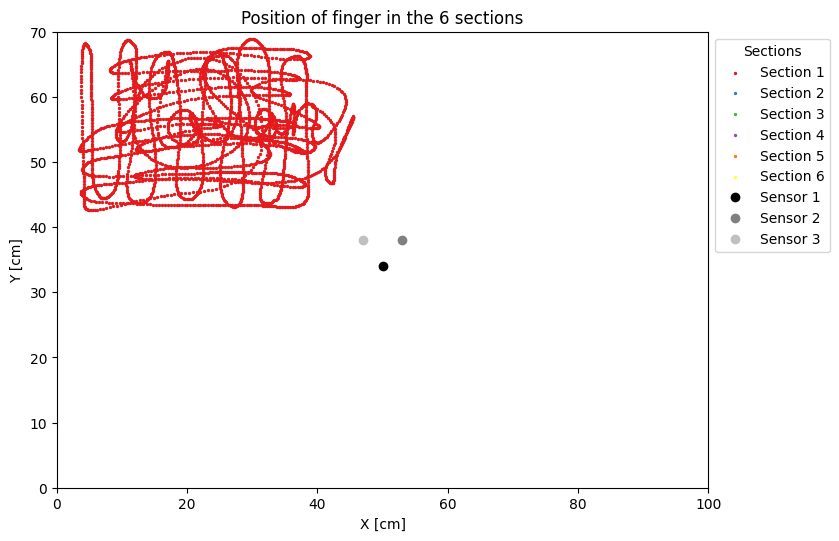

In [10]:

palette = sns.color_palette("Set1")

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(training_data_all[training_data_all.section == "section_1"].x, training_data_all[training_data_all.section == "section_1"].y, label="Section 1", s=2, c=palette[0])
ax.scatter(training_data_all[training_data_all.section == "section_2"].x, training_data_all[training_data_all.section == "section_2"].y, label="Section 2", s=2, c=palette[1])
ax.scatter(training_data_all[training_data_all.section == "section_3"].x, training_data_all[training_data_all.section == "section_3"].y, label="Section 3", s=2, c=palette[2])
ax.scatter(training_data_all[training_data_all.section == "section_4"].x, training_data_all[training_data_all.section == "section_4"].y, label="Section 4", s=2, c=palette[3])
ax.scatter(training_data_all[training_data_all.section == "section_5"].x, training_data_all[training_data_all.section == "section_5"].y, label="Section 5", s=2, c=palette[4])
ax.scatter(training_data_all[training_data_all.section == "section_6"].x, training_data_all[training_data_all.section == "section_6"].y, label="Section 6", s=2, c=palette[5])



s1 = [50, 34]
s2 = [53, 38]
s3 = [47, 38]

palette = sns.color_palette("flag")

ax.plot(s1[0], s1[1], "o", label="Sensor 1", c="black")
ax.plot(s2[0], s2[1], "o", label="Sensor 2", c="grey")
ax.plot(s3[0], s3[1], "o", label="Sensor 3", c="silver")



ax.set_aspect('equal')
ax.set_xlim(0,100)
ax.set_ylim(0,70)
ax.set_xlabel("X [cm]")
ax.set_ylabel("Y [cm]")
# Place the legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Sections")

ax.set_title("Position of finger in the 6 sections")
fig.tight_layout(rect=[0,0,0.85,1])  # Adjust the right side of the plot box to make space for the legend



C:\Users\malan\AppData\Local\Temp\ipykernel_11024\64827225.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=training_data_all, x='section', palette='Set1')


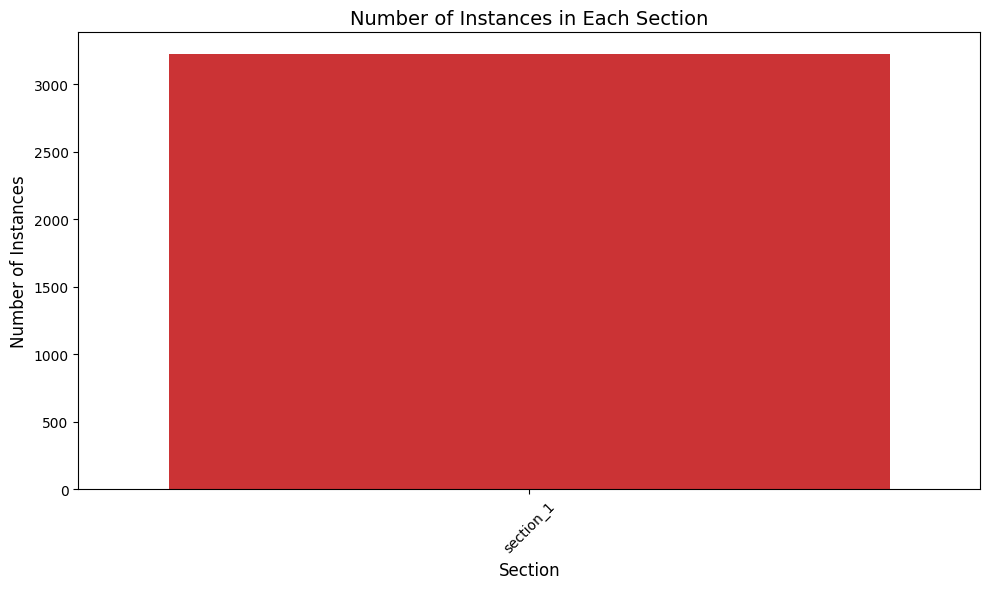

In [11]:
plt.figure(figsize=(10, 6)) 

ax = sns.countplot(data=training_data_all, x='section', palette='Set1')
ax.set_xlabel("Section", fontsize=12)
ax.set_ylabel("Number of Instances", fontsize=12)
ax.set_title("Number of Instances in Each Section", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()  
plt.show()

#### Plotting the distribution in dx and dy

C:\Users\malan\AppData\Local\Temp\ipykernel_11024\309423140.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(training_data_all[training_data_all.section == "section_1"].dx, training_data_all[training_data_all.section == "section_1"].dy, label="Section 1", s=2, c=palette[0])
C:\Users\malan\AppData\Local\Temp\ipykernel_11024\309423140.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(training_data_al

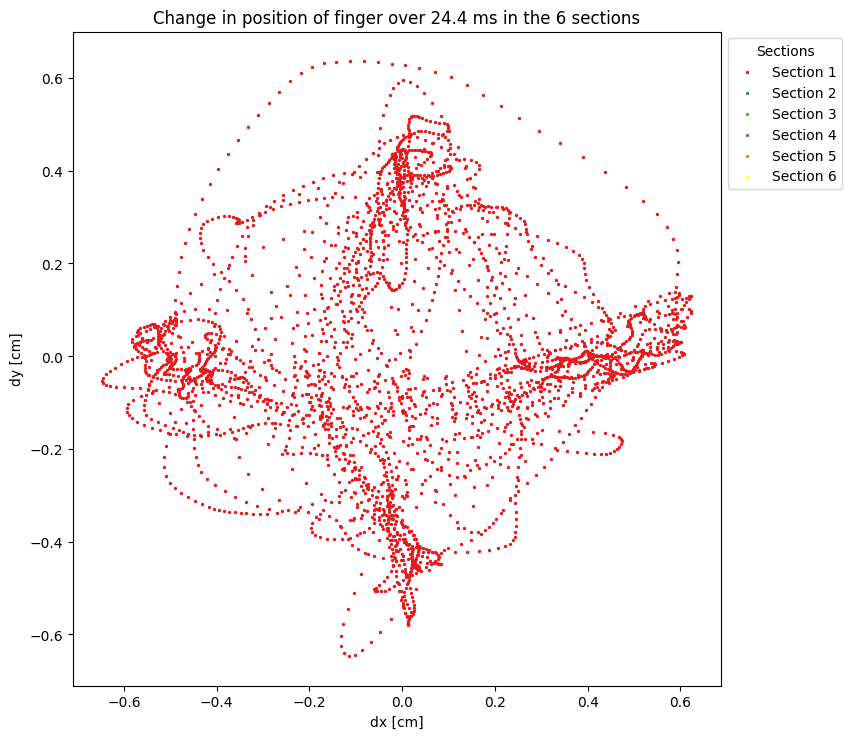

In [12]:
palette = sns.color_palette("Set1")
fig, ax = plt.subplots(figsize=(10, 10))

# Map each section to a color from the Set1 palette
ax.scatter(training_data_all[training_data_all.section == "section_1"].dx, training_data_all[training_data_all.section == "section_1"].dy, label="Section 1", s=2, c=palette[0])
ax.scatter(training_data_all[training_data_all.section == "section_2"].dx, training_data_all[training_data_all.section == "section_2"].dy, label="Section 2", s=2, c=palette[1])
ax.scatter(training_data_all[training_data_all.section == "section_3"].dx, training_data_all[training_data_all.section == "section_3"].dy, label="Section 3", s=2, c=palette[2])
ax.scatter(training_data_all[training_data_all.section == "section_4"].dx, training_data_all[training_data_all.section == "section_4"].dy, label="Section 4", s=2, c=palette[3])
ax.scatter(training_data_all[training_data_all.section == "section_5"].dx, training_data_all[training_data_all.section == "section_5"].dy, label="Section 5", s=2, c=palette[4])
ax.scatter(training_data_all[training_data_all.section == "section_6"].dx, training_data_all[training_data_all.section == "section_6"].dy, label="Section 6", s=2, c=palette[5])
ax.set_aspect('equal')
ax.set_xlabel("dx [cm]")
ax.set_ylabel("dy [cm]")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Sections")
ax.set_title("Change in position of finger over 24.4 ms in the 6 sections")
fig.tight_layout(rect=[0,0,0.85,1]) 

C:\Users\malan\AppData\Local\Temp\ipykernel_11024\445197489.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(training_data_all[training_data_all.section == "section_1"].ddx, training_data_all[training_data_all.section == "section_1"].ddy, label="Section 1", s=2, c=palette[0])
C:\Users\malan\AppData\Local\Temp\ipykernel_11024\445197489.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(training_data_

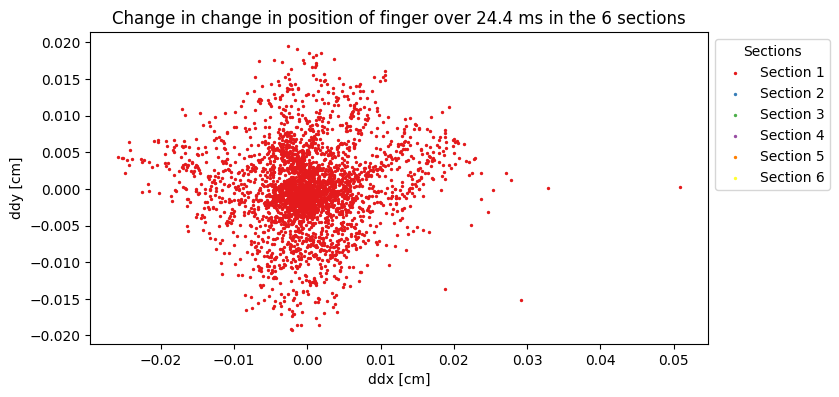

In [13]:
palette = sns.color_palette("Set1")
fig, ax = plt.subplots(figsize=(10, 10))

# Map each section to a color from the Set1 palette
ax.scatter(training_data_all[training_data_all.section == "section_1"].ddx, training_data_all[training_data_all.section == "section_1"].ddy, label="Section 1", s=2, c=palette[0])
ax.scatter(training_data_all[training_data_all.section == "section_2"].ddx, training_data_all[training_data_all.section == "section_2"].ddy, label="Section 2", s=2, c=palette[1])
ax.scatter(training_data_all[training_data_all.section == "section_3"].ddx, training_data_all[training_data_all.section == "section_3"].ddy, label="Section 3", s=2, c=palette[2])
ax.scatter(training_data_all[training_data_all.section == "section_4"].ddx, training_data_all[training_data_all.section == "section_4"].ddy, label="Section 4", s=2, c=palette[3])
ax.scatter(training_data_all[training_data_all.section == "section_5"].ddx, training_data_all[training_data_all.section == "section_5"].ddy, label="Section 5", s=2, c=palette[4])
ax.scatter(training_data_all[training_data_all.section == "section_6"].ddx, training_data_all[training_data_all.section == "section_6"].ddy, label="Section 6", s=2, c=palette[5])
ax.set_aspect('equal')
ax.set_xlabel("ddx [cm]")
ax.set_ylabel("ddy [cm]")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Sections")
ax.set_title("Change in change in position of finger over 24.4 ms in the 6 sections")
fig.tight_layout(rect=[0,0,0.85,1]) 

#### Changing the x coordinate to be the distance from origo to the finger

In [14]:
origo = [50, 35]

training_data_all["x"] = training_data_all.x - origo[0]
training_data_all["y"] = training_data_all.y - origo[1]



C:\Users\malan\AppData\Local\Temp\ipykernel_11024\4272310266.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(training_data_all[training_data_all.section == "section_1"].x, training_data_all[training_data_all.section == "section_1"].y, label="Section 1", s=2, c=palette[0])
C:\Users\malan\AppData\Local\Temp\ipykernel_11024\4272310266.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(training_data_al

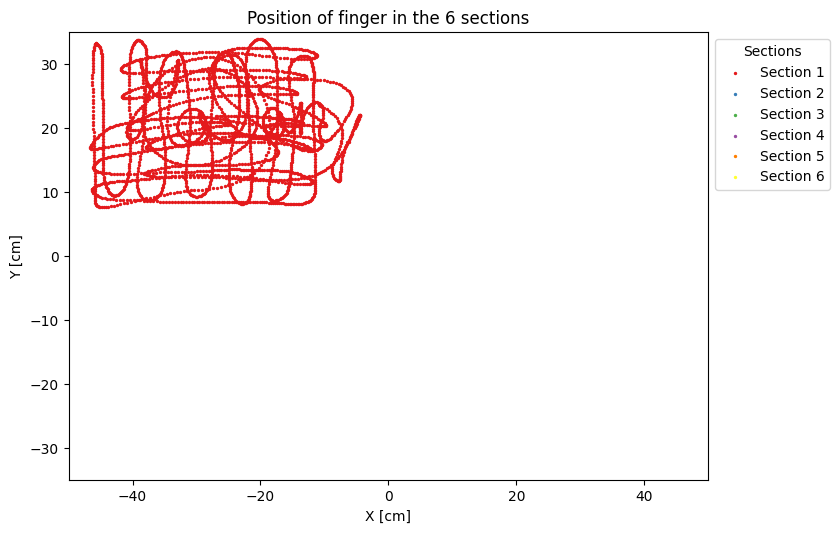

In [15]:

palette = sns.color_palette("Set1")

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(training_data_all[training_data_all.section == "section_1"].x, training_data_all[training_data_all.section == "section_1"].y, label="Section 1", s=2, c=palette[0])
ax.scatter(training_data_all[training_data_all.section == "section_2"].x, training_data_all[training_data_all.section == "section_2"].y, label="Section 2", s=2, c=palette[1])
ax.scatter(training_data_all[training_data_all.section == "section_3"].x, training_data_all[training_data_all.section == "section_3"].y, label="Section 3", s=2, c=palette[2])
ax.scatter(training_data_all[training_data_all.section == "section_4"].x, training_data_all[training_data_all.section == "section_4"].y, label="Section 4", s=2, c=palette[3])
ax.scatter(training_data_all[training_data_all.section == "section_5"].x, training_data_all[training_data_all.section == "section_5"].y, label="Section 5", s=2, c=palette[4])
ax.scatter(training_data_all[training_data_all.section == "section_6"].x, training_data_all[training_data_all.section == "section_6"].y, label="Section 6", s=2, c=palette[5])



ax.set_aspect('equal')
ax.set_xlim(-50, 50 )
ax.set_ylim(-35, 35)
ax.set_xlabel("X [cm]")
ax.set_ylabel("Y [cm]")
# Place the legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Sections")

ax.set_title("Position of finger in the 6 sections")
fig.tight_layout(rect=[0,0,0.85,1])  # Adjust the right side of the plot box to make space for the legend



#### filtering the training data

In [16]:


# Only including instances where the distance from origo 0, 0 is less than 25 cm
training_data_all = training_data_all[training_data_all.x**2 + training_data_all.y**2 < radius_position**2]

# only including instances where the velocity is greater than 0.5 cm/ms
training_data_all = training_data_all[training_data_all.dx**2 + training_data_all.dy**2 > radius_velocity**2]

# Adding a column with the direction vector
training_data_all["direction"] = training_data_all.apply(lambda row: determine_direction(row["dx"], row["dy"], num_sectors), axis=1)
training_data_all["direction_label"] = training_data_all["direction"].apply(lambda x: np.argmax(x))


In [17]:
training_data_all.direction.value_counts()

direction
[1, 0, 0, 0, 0, 0, 0, 0]    719
[0, 0, 0, 0, 1, 0, 0, 0]    611
[0, 0, 1, 0, 0, 0, 0, 0]    556
[0, 0, 0, 0, 0, 0, 1, 0]    523
[0, 0, 0, 0, 0, 1, 0, 0]    260
[0, 0, 0, 0, 0, 0, 0, 1]    199
[0, 0, 0, 1, 0, 0, 0, 0]    197
[0, 1, 0, 0, 0, 0, 0, 0]    158
Name: count, dtype: int64

C:\Users\malan\AppData\Local\Temp\ipykernel_11024\499801006.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(training_data_all[training_data_all.section == "section_1"].x, training_data_all[training_data_all.section == "section_1"].y, label="Section 1", s=2, c=palette[0])
C:\Users\malan\AppData\Local\Temp\ipykernel_11024\499801006.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(training_dat

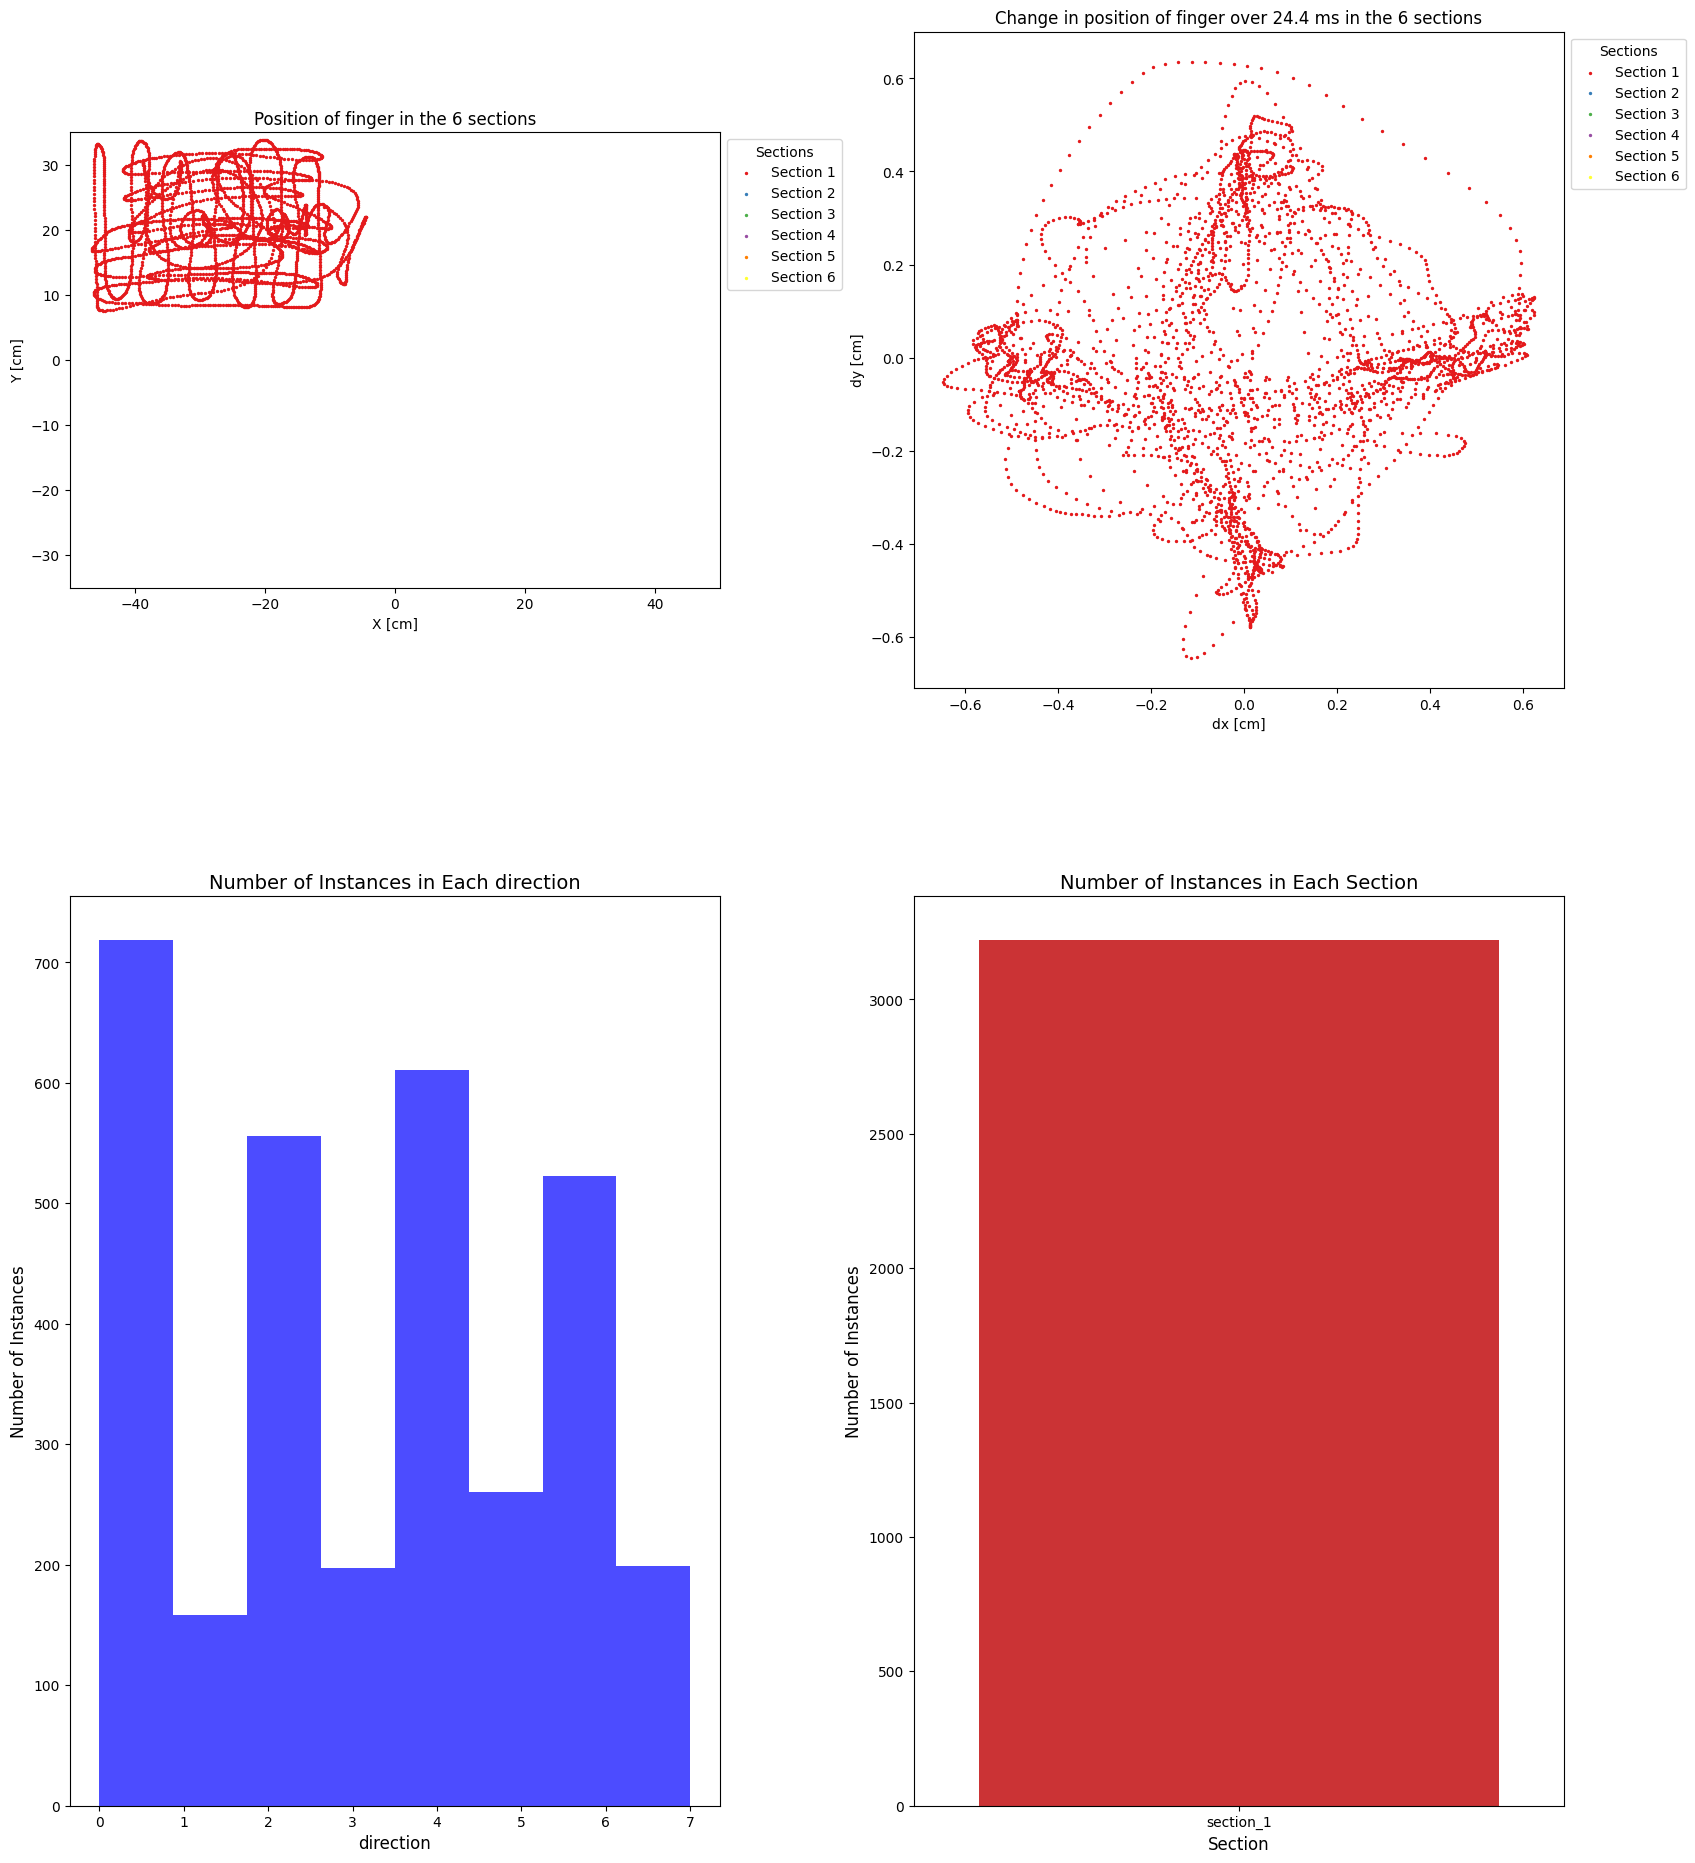

In [18]:
fig, ax = plt.subplots(2,2, figsize=(20, 20))
ax = ax.ravel()
palette = sns.color_palette("Set1")
ax[0].scatter(training_data_all[training_data_all.section == "section_1"].x, training_data_all[training_data_all.section == "section_1"].y, label="Section 1", s=2, c=palette[0])
ax[0].scatter(training_data_all[training_data_all.section == "section_2"].x, training_data_all[training_data_all.section == "section_2"].y, label="Section 2", s=2, c=palette[1])
ax[0].scatter(training_data_all[training_data_all.section == "section_3"].x, training_data_all[training_data_all.section == "section_3"].y, label="Section 3", s=2, c=palette[2])
ax[0].scatter(training_data_all[training_data_all.section == "section_4"].x, training_data_all[training_data_all.section == "section_4"].y, label="Section 4", s=2, c=palette[3])
ax[0].scatter(training_data_all[training_data_all.section == "section_5"].x, training_data_all[training_data_all.section == "section_5"].y, label="Section 5", s=2, c=palette[4])
ax[0].scatter(training_data_all[training_data_all.section == "section_6"].x, training_data_all[training_data_all.section == "section_6"].y, label="Section 6", s=2, c=palette[5])
ax[0].set_aspect('equal')
ax[0].set_xlim(-50, 50 )
ax[0].set_ylim(-35, 35)
ax[0].set_xlabel("X [cm]")
ax[0].set_ylabel("Y [cm]")
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1), title="Sections")
ax[0].set_title("Position of finger in the 6 sections")


ax[1].scatter(training_data_all[training_data_all.section == "section_1"].dx, training_data_all[training_data_all.section == "section_1"].dy, label="Section 1", s=2, c=palette[0])
ax[1].scatter(training_data_all[training_data_all.section == "section_2"].dx, training_data_all[training_data_all.section == "section_2"].dy, label="Section 2", s=2, c=palette[1])
ax[1].scatter(training_data_all[training_data_all.section == "section_3"].dx, training_data_all[training_data_all.section == "section_3"].dy, label="Section 3", s=2, c=palette[2])
ax[1].scatter(training_data_all[training_data_all.section == "section_4"].dx, training_data_all[training_data_all.section == "section_4"].dy, label="Section 4", s=2, c=palette[3])
ax[1].scatter(training_data_all[training_data_all.section == "section_5"].dx, training_data_all[training_data_all.section == "section_5"].dy, label="Section 5", s=2, c=palette[4])
ax[1].scatter(training_data_all[training_data_all.section == "section_6"].dx, training_data_all[training_data_all.section == "section_6"].dy, label="Section 6", s=2, c=palette[5])
ax[1].set_aspect('equal')
ax[1].set_xlabel("dx [cm]")
ax[1].set_ylabel("dy [cm]")
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1), title="Sections")
ax[1].set_title("Change in position of finger over 24.4 ms in the 6 sections")

ax[2].hist(training_data_all.direction_label, bins=num_sectors, color='blue', alpha=0.7)
ax[2].set_xlabel("direction", fontsize=12)
ax[2].set_ylabel("Number of Instances", fontsize=12)
ax[2].set_title("Number of Instances in Each direction", fontsize=14)

ax[3] = sns.countplot(data=training_data_all, x='section', palette='Set1')
ax[3].set_xlabel("Section", fontsize=12)
ax[3].set_ylabel("Number of Instances", fontsize=12)
ax[3].set_title("Number of Instances in Each Section", fontsize=14)





fig.tight_layout(rect=[0,0,0.85,1])  



In [21]:
import numpy as np
-np.log(1/8)

2.0794415416798357

In [20]:
# saving the filtered data
training_data_all.to_pickle(rf"processed_data\all_data_filtered_velocity_{radius_velocity}_radius_{radius_position}_num_sectors_{num_sectors}.pkl")

In [32]:
training_data_all.shape


(3223, 13)